<a href="https://colab.research.google.com/github/ka-means/Process-Mining-/blob/main/USING_THE_ALPHA_MINING_ALGORITHM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img src="https://web-uc-prod.s3.amazonaws.com/img/logo-uc-chile.svg" alt="logoUC" width="40%" align="right" hspace="10px" vspace="0px"></p>

**Autores:**
* Luciano Hidalgo (lhidalgo1@uc.cl),
* Ignacio Velásquez (iavelasquez@uc.cl)

*Versión Original:*
* Victor Gálvez (vagalvez@uc.cl)


# **USING THE ALPHA ALGORITHM**

Para correr este notebook se utiliza un archivo de log de eventos de Reparación de Vehículos:

* Log de eventos en formato CSV: <AGREGAR LINK>

Al correr el notebook de manera local, este archivo debe ser descargado y ubicado en la misma carpeta del notebook. Sin embargo, si nos encontramos trabajando en Google Colab, la siguiente celda permite cargar los archivos directamente a la memoria de la sesión actual de Colab.

In [ ]:
from IPython.display import clear_output

# El siguiente código sólo se ejecuta si nos encontramos en ambiente Google Colab
if 'google.colab' in str(get_ipython()):

  # Log de eventos en formato CSV
  !gdown --id 12jaCdN3bF8kx2Sq1q86WlWLy5LrDFCeh

clear_output()
print("Log 'Reparacion Vehiculos.csv' cargado.")

Log 'Reparacion Vehiculos.csv' cargado.


## 1. Preliminares

Al igual que el tutorial pasado, instalaremos pm4py para poder usar las funciones de este módulo en Python y luego utilizaremos las funciones para cargar nuestro *event log*.

### PM4Py

Para instalar el módulo se utiliza el comando:

    pip install pm4py

In [ ]:
!pip install pm4py

clear_output()
print("PM4Py instalado.")

PM4Py instalado.


### Documentación

En caso de requerir más información para la instalación de PM4Py, se puede acceder al siguiente enlace: https://pm4py.fit.fraunhofer.de/static/assets/api/2.7.8/install.html

La documentación oficial del módulo puede ser encontrada en: https://pm4py.fit.fraunhofer.de/static/assets/api/2.7.8/index.html

El repositorio GitHub del módulo es: https://github.com/pm4py/pm4py-core

### Leer CSV

In [ ]:
import pandas as pd
import pm4py

log_csv = pd.read_csv('reparacion_vehiculos.csv', sep = ';')

log_csv = pm4py.format_dataframe(log_csv,
                                case_id='ID Caso',
                                activity_key='Actividad',
                                timestamp_key='Fin',
                                timest_format  = '%Y-%m-%d %H:%M:%S')

In [ ]:
log_csv.head()

,ID Caso,Actividad,Inicio,Fin,Ejecutor,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,1,Recibir vehiculo,2023-07-17 08:00:20+00:00,2023-07-17 08:15:21+00:00,Pablo,1,Recibir vehiculo,2023-07-17 08:15:21+00:00,0,0
1,1,Elaborar presupuesto,2023-07-17 08:34:30+00:00,2023-07-17 09:25:31+00:00,Norma,1,Elaborar presupuesto,2023-07-17 09:25:31+00:00,1,0
2,1,Enviar presupuesto a cliente,2023-07-17 09:45:16+00:00,2023-07-17 09:50:25+00:00,Gabriela,1,Enviar presupuesto a cliente,2023-07-17 09:50:25+00:00,2,0
3,1,Recibir respuesta,2023-07-17 11:34:47+00:00,2023-07-17 11:34:47+00:00,Gabriela,1,Recibir respuesta,2023-07-17 11:34:47+00:00,3,0
4,1,Coordinar retiro,2023-07-18 08:06:42+00:00,2023-07-18 08:20:18+00:00,Gabriela,1,Coordinar retiro,2023-07-18 08:20:18+00:00,4,0


## 2. Aplicando el algoritmo Alpha

En primer lugar, podemos ver lo que hace pm4py internamente usando la función `pm4py.discovery.discover_footprints()`, esta recibe un event log y nos entrega un diccionario con varios elementos.

In [ ]:
footprints_log = pm4py.discovery.discover_footprints(log_csv)

footprints_log.keys()

dict_keys(['dfg', 'sequence', 'parallel', 'activities', 'start_activities', 'end_activities', 'min_trace_length'])

En particular, estos elementos se corresponden a varios de los conjuntos usados en el algoritmo alpha.

* dfg, corresponde al conjunto de todas las actividades con sucesión directa o *directly follows* $(a > b)$.
* sequence, corresponde al conjunto de causalidad $(a → b)$.
* parallel, corresponde al conjunto de paralelismo $(a || b)$.
* start_activities, representa todas las actividades con las que comienza alguna traza.
* end_activities, representa todas las actividades con las que termina alguna traza.
* min_trace_length, es el largo de la traza más corta.


In [ ]:
footprints_log['sequence']

{('Comprar repuestos', 'Recibir repuestos'),
 ('Coordinar retiro', 'Entregar vehiculo'),
 ('Elaborar presupuesto', 'Enviar presupuesto a cliente'),
 ('Enviar presupuesto a cliente', 'Coordinar retiro'),
 ('Enviar presupuesto a cliente', 'Recibir respuesta'),
 ('Instalar repuestos', 'Pintar vehiculo'),
 ('Pintar vehiculo', 'Probar vehiculo'),
 ('Probar vehiculo', 'Comprar repuestos'),
 ('Probar vehiculo', 'Entregar vehiculo'),
 ('Probar vehiculo', 'Instalar repuestos'),
 ('Probar vehiculo', 'Restaurar danos'),
 ('Recibir repuestos', 'Instalar repuestos'),
 ('Recibir respuesta', 'Comprar repuestos'),
 ('Recibir respuesta', 'Coordinar retiro'),
 ('Recibir respuesta', 'Restaurar danos'),
 ('Recibir vehiculo', 'Elaborar presupuesto'),
 ('Restaurar danos', 'Pintar vehiculo')}

In [ ]:
footprints_log['parallel']

{('Comprar repuestos', 'Restaurar danos'),
 ('Instalar repuestos', 'Restaurar danos'),
 ('Recibir repuestos', 'Restaurar danos'),
 ('Restaurar danos', 'Comprar repuestos'),
 ('Restaurar danos', 'Instalar repuestos'),
 ('Restaurar danos', 'Recibir repuestos')}

In [ ]:
footprints_log['start_activities']

{'Recibir vehiculo'}

In [ ]:
footprints_log['end_activities']

{'Comprar repuestos',
 'Coordinar retiro',
 'Entregar vehiculo',
 'Enviar presupuesto a cliente',
 'Instalar repuestos',
 'Probar vehiculo',
 'Recibir repuestos',
 'Recibir respuesta',
 'Restaurar danos'}

Si entregamos este diccionario de relaciones entre actividades a la función `.vis.view_footprints()` obtendremos la matriz de huellas o *footprint matrix* que usamos en el algoritmo para construir los conjuntos $X$ e $Y$ del algoritmo alpha.

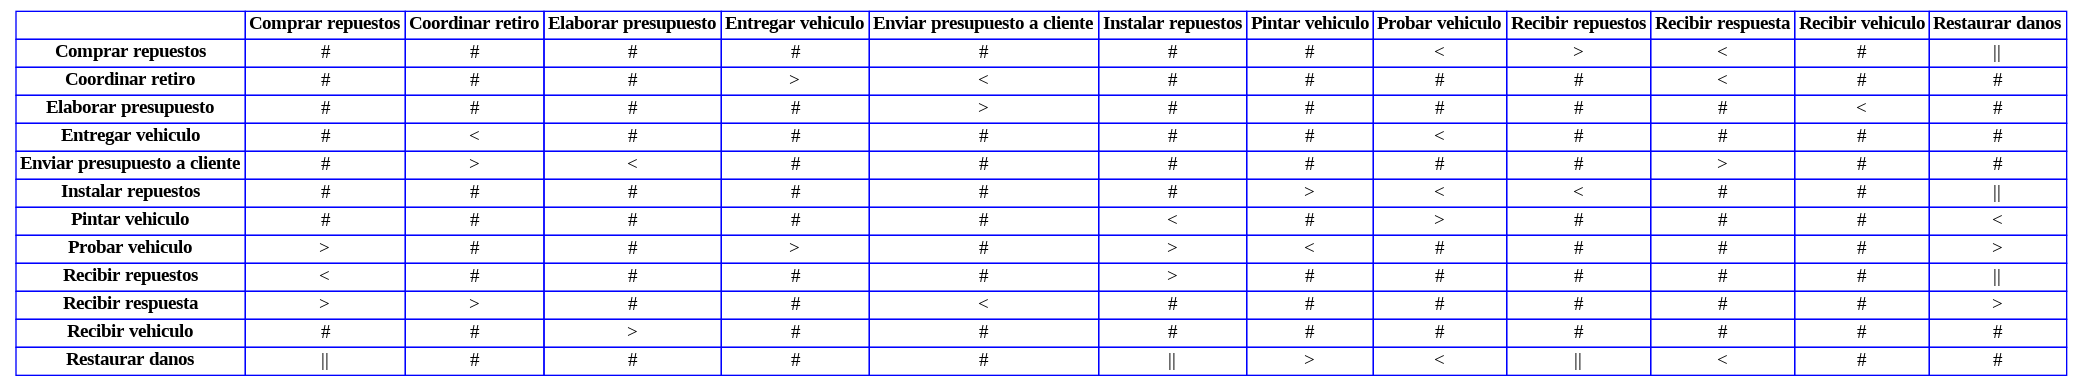

In [ ]:
pm4py.vis.view_footprints(footprints_log, format='png')

Ahora, para aplicar el algoritmo alpha, pm4py tiene implementada la función` pm4py.discovery.discover_petri_net_alpha()`, que recibe como entrada un log de eventos y devuelve 3 elementos:
* La red de petri, que contiene los *places* y *transitions* que conforman la red.
* El inital marking de la red, indicando los *tokens* que tiene el estado inicial.
* El final marking de la red, indicando cuál es el estado final.

In [ ]:
net, initial_marking, final_marking = pm4py.discovery.discover_petri_net_alpha(log_csv)

In [ ]:
net

places: [ ({'Comprar repuestos'}, {'Recibir repuestos'}), ({'Coordinar retiro', 'Probar vehiculo'}, {'Entregar vehiculo'}), ({'Elaborar presupuesto'}, {'Enviar presupuesto a cliente'}), ({'Enviar presupuesto a cliente'}, {'Coordinar retiro'}), ({'Enviar presupuesto a cliente'}, {'Recibir respuesta'}), ({'Instalar repuestos'}, {'Pintar vehiculo'}), ({'Pintar vehiculo'}, {'Probar vehiculo'}), ({'Probar vehiculo'}, {'Entregar vehiculo', 'Instalar repuestos', 'Comprar repuestos'}), ({'Probar vehiculo'}, {'Entregar vehiculo', 'Restaurar danos'}), ({'Recibir repuestos', 'Probar vehiculo'}, {'Instalar repuestos'}), ({'Recibir respuesta', 'Probar vehiculo'}, {'Comprar repuestos'}), ({'Recibir respuesta', 'Probar vehiculo'}, {'Restaurar danos'}), ({'Recibir respuesta'}, {'Coordinar retiro', 'Comprar repuestos'}), ({'Recibir respuesta'}, {'Coordinar retiro', 'Restaurar danos'}), ({'Recibir vehiculo'}, {'Elaborar presupuesto'}), ({'Restaurar danos'}, {'Pintar vehiculo'}), end, start ]
transitions

Ahora, para visualizar la red de Petri, podemos usar la función `vis.view_petri_net()`. Esta nos permite visualizar la red como imagen. En este ejemplo en particular la mostraremos en .png, sin embargo, pmp4y admite varios formatos de guardado como svg, jpeg, entre otros.

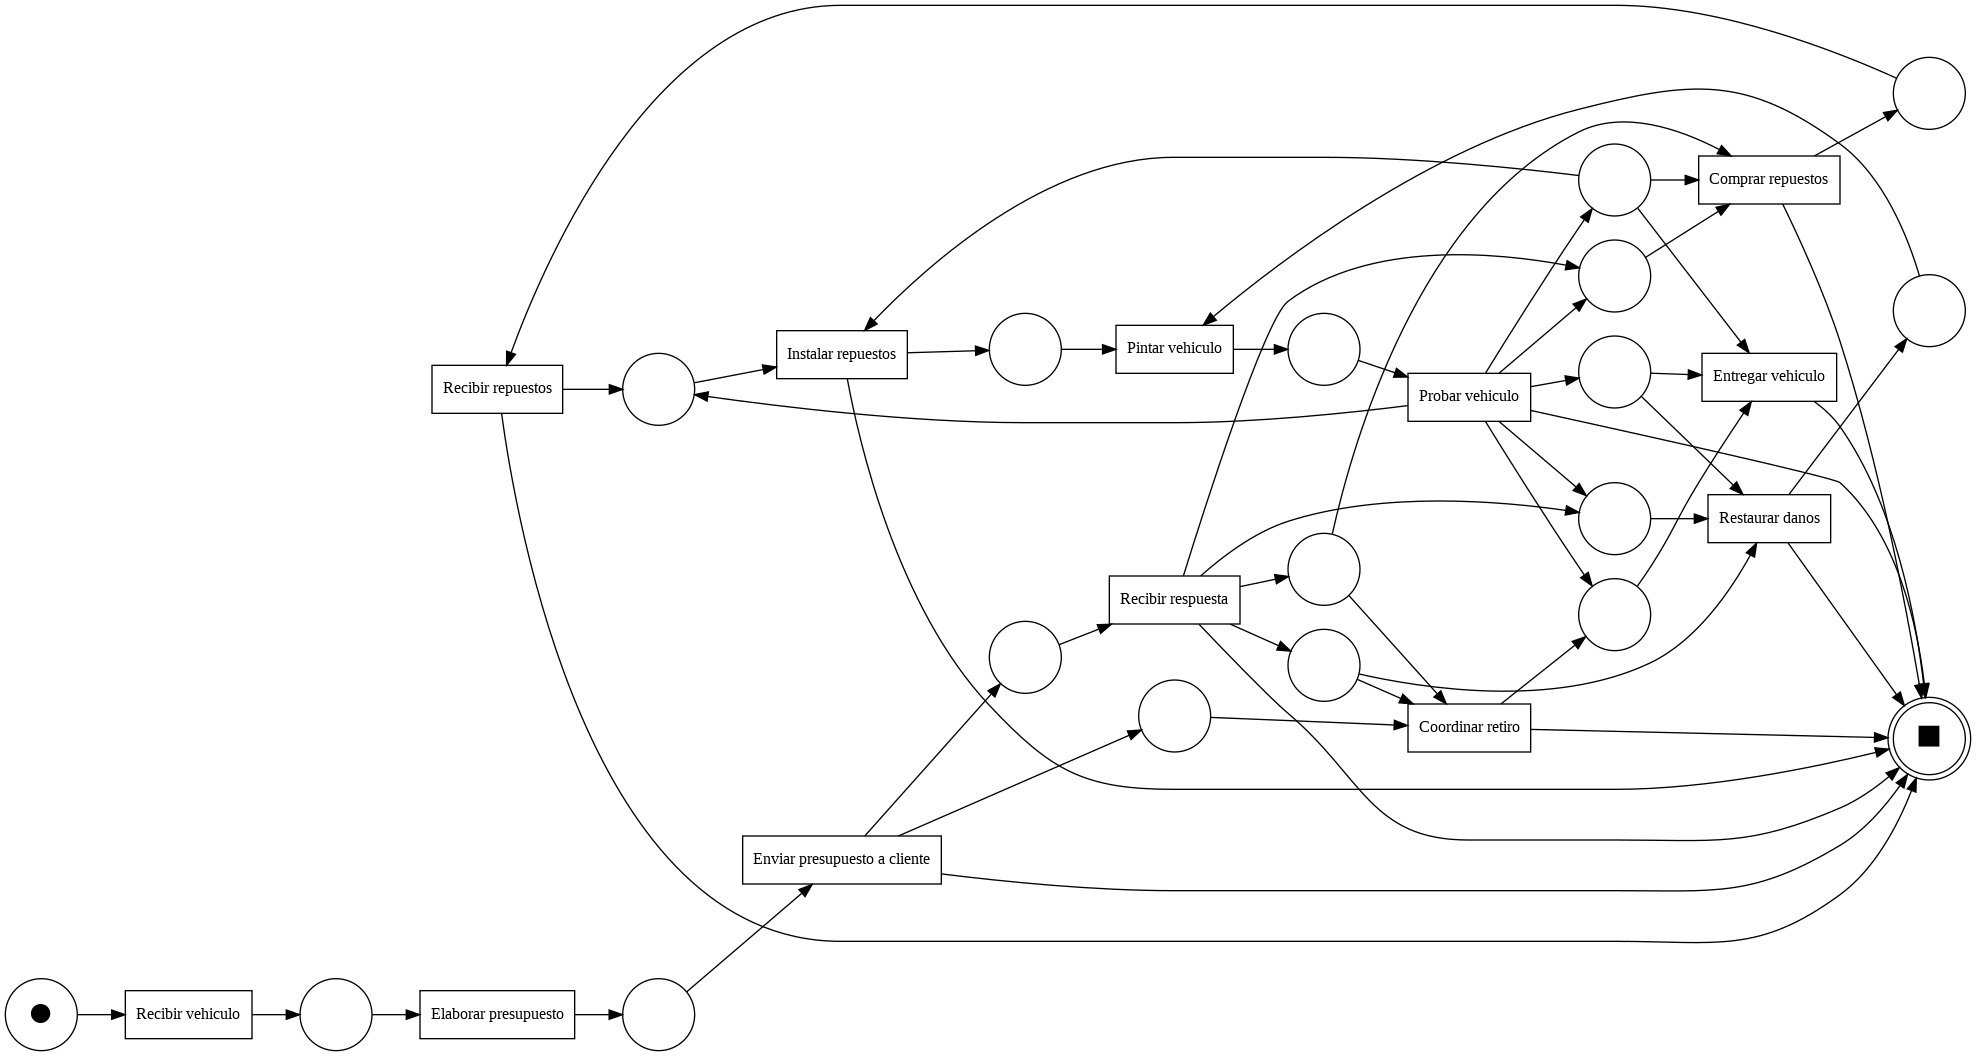

In [ ]:
# Para ver la visualización
pm4py.vis.view_petri_net(net,
                         initial_marking,
                         final_marking,
                         format = 'png')

Del mismo modo, podemos guardar una red de Petri como imagen usando la `función vis.save_vis_petri_net()`, esta requiere los mismos parámetros que la función anterior, con la diferencia que, en vez de un parámetro `format`, esta requiere un parámetro `file_path` indicando la ruta y la extensión para guardar el archivo.

In [ ]:
# Para guardar la visualización
pm4py.vis.save_vis_petri_net(net,
                             initial_marking,
                             final_marking,
                             file_path = "petri_net_alpha.png")

También podemos usar el dfg que obtuvimos al calcular la matriz de huellas para visualizar el *directly follows graph* `pm4py.vis.view_dfg()`

In [ ]:
footprints_log['dfg']

{('Comprar repuestos', 'Recibir repuestos'): 743,
 ('Comprar repuestos', 'Restaurar danos'): 126,
 ('Coordinar retiro', 'Entregar vehiculo'): 120,
 ('Elaborar presupuesto', 'Enviar presupuesto a cliente'): 938,
 ('Enviar presupuesto a cliente', 'Coordinar retiro'): 43,
 ('Enviar presupuesto a cliente', 'Recibir respuesta'): 882,
 ('Instalar repuestos', 'Pintar vehiculo'): 510,
 ('Instalar repuestos', 'Restaurar danos'): 282,
 ('Pintar vehiculo', 'Probar vehiculo'): 790,
 ('Probar vehiculo', 'Comprar repuestos'): 47,
 ('Probar vehiculo', 'Entregar vehiculo'): 663,
 ('Probar vehiculo', 'Instalar repuestos'): 3,
 ('Probar vehiculo', 'Restaurar danos'): 54,
 ('Recibir repuestos', 'Instalar repuestos'): 518,
 ('Recibir repuestos', 'Restaurar danos'): 277,
 ('Recibir respuesta', 'Comprar repuestos'): 727,
 ('Recibir respuesta', 'Coordinar retiro'): 84,
 ('Recibir respuesta', 'Restaurar danos'): 61,
 ('Recibir vehiculo', 'Elaborar presupuesto'): 938,
 ('Restaurar danos', 'Comprar repuestos'):

In [ ]:
dfg = footprints_log['dfg']

start_activities = footprints_log['start_activities']

end_activities = footprints_log['end_activities']

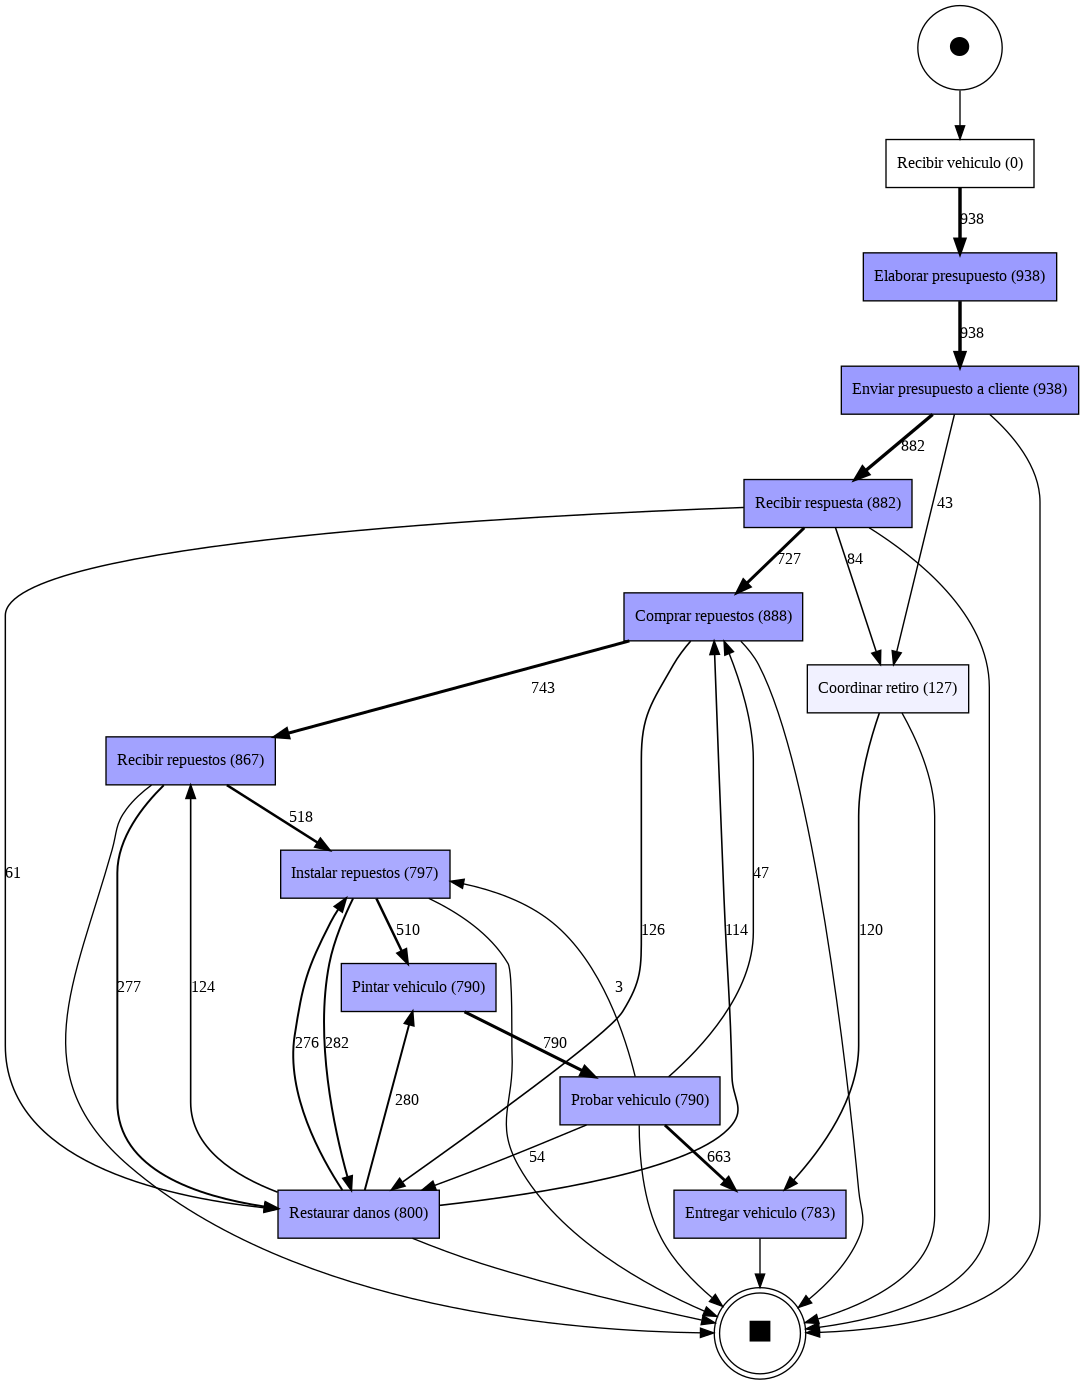

In [ ]:
pm4py.vis.view_dfg(dfg,
                   start_activities,
                   end_activities,
                   format = 'png',
                   rankdir='TB')

## 3. Aplicando el algoritmo alpha sobre el log filtrado

Tanto la red de Petri, como el *directly-follows graph* indican que el proceso no termina en "Entregar vehículo" en todos los casos.

Por ello, podemos usar el mismo filtro del tutorial pasado. Crearemos una versión del log solo con los casos que terminan en "Entregar vehículo" y aplicaremos nuevamente el algoritmo.

In [ ]:
log_filtrado = pm4py.filtering.filter_end_activities(log_csv, ['Entregar vehiculo'])

In [ ]:
footprints_filtrado = pm4py.discovery.discover_footprints(log_filtrado)

Podemos ver que en este log filtrado solo queda una actividad de fin.

In [ ]:
footprints_filtrado['end_activities']

{'Entregar vehiculo'}

Y obtener nuevamente la matriz de huellas

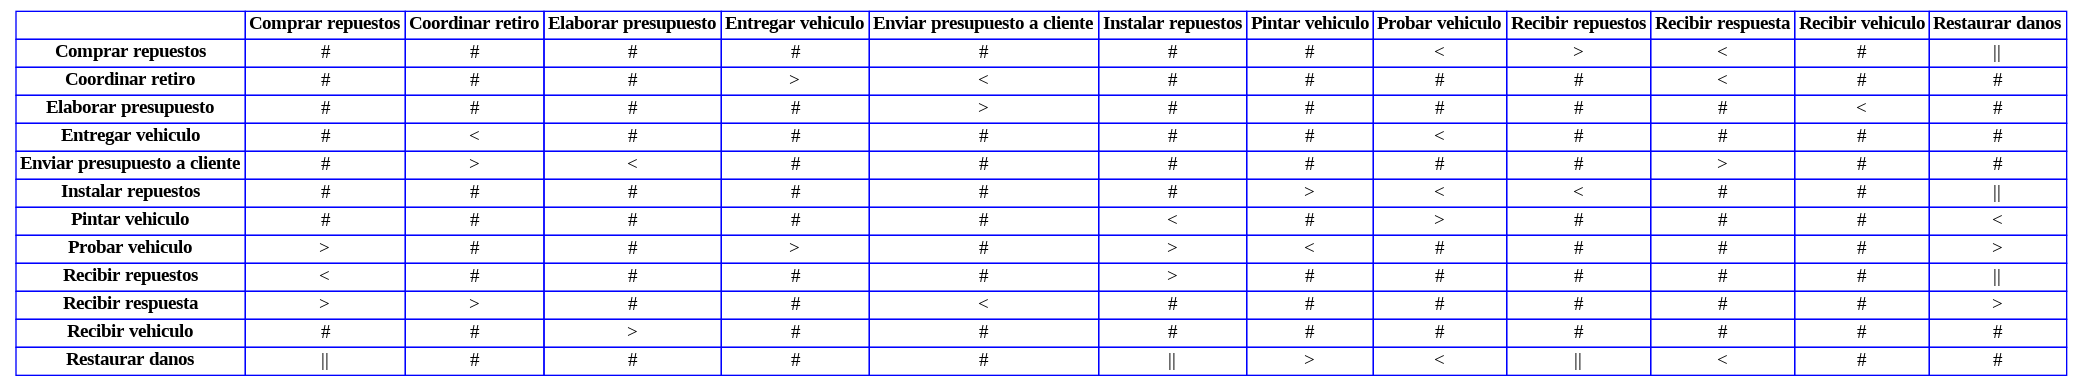

In [ ]:
pm4py.vis.view_footprints(footprints_filtrado, format='png')

Y mostrar como se vería la red de Petri al aplicar el algoritmo sobre este log.

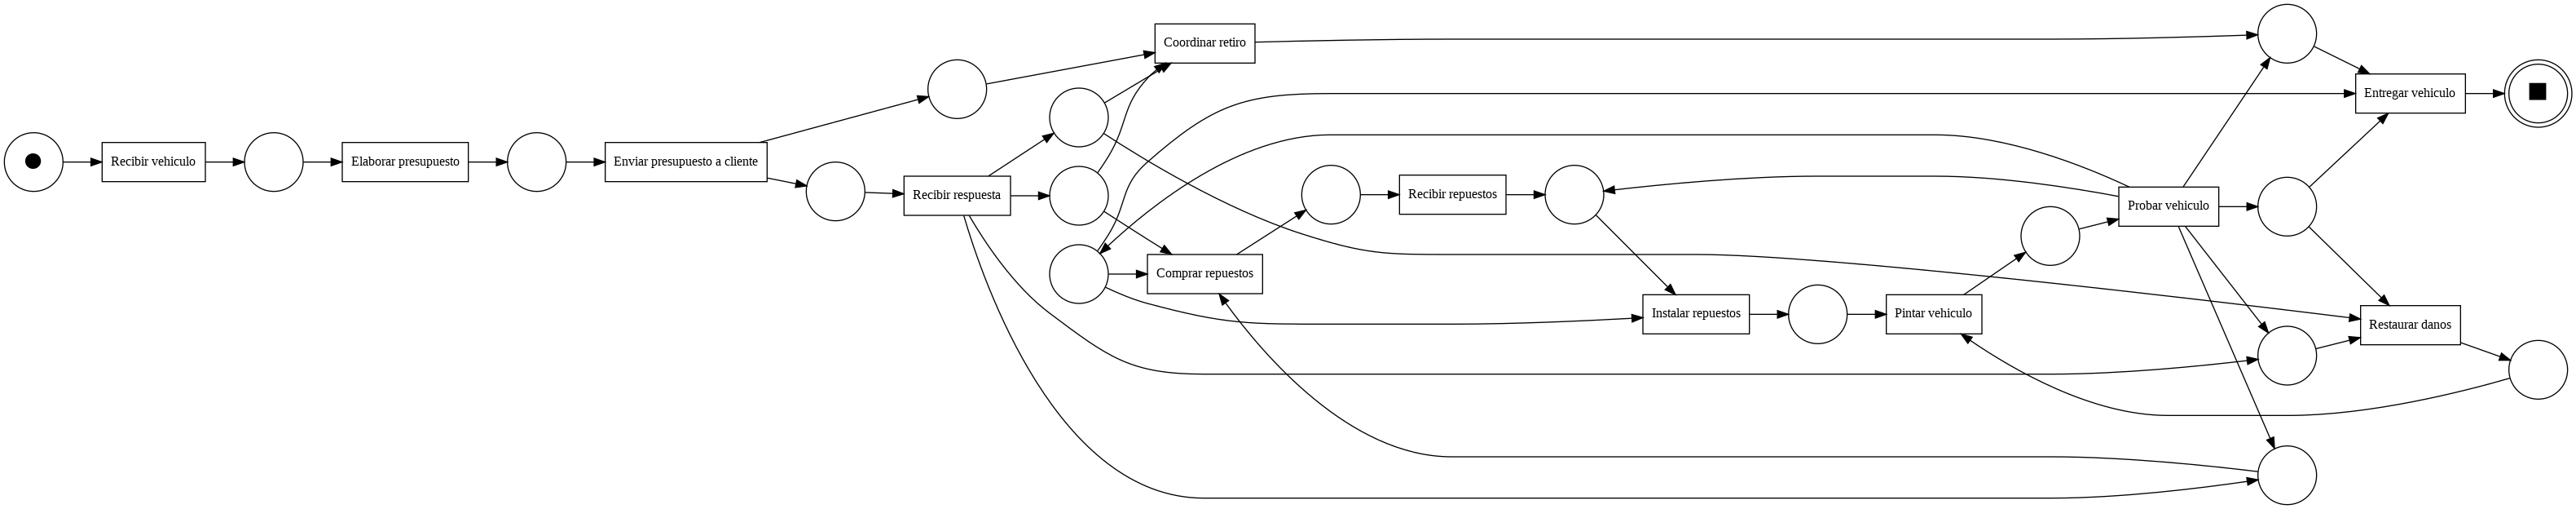

In [ ]:
net, initial_marking, final_marking = pm4py.discovery.discover_petri_net_alpha(log_filtrado.copy())
pm4py.vis.view_petri_net(net,
                         initial_marking,
                         final_marking,
                         format = 'png')

De igual modo, también esta matriz de huellas nos permite mostrar el *directly-follows graph* asociado a este log.

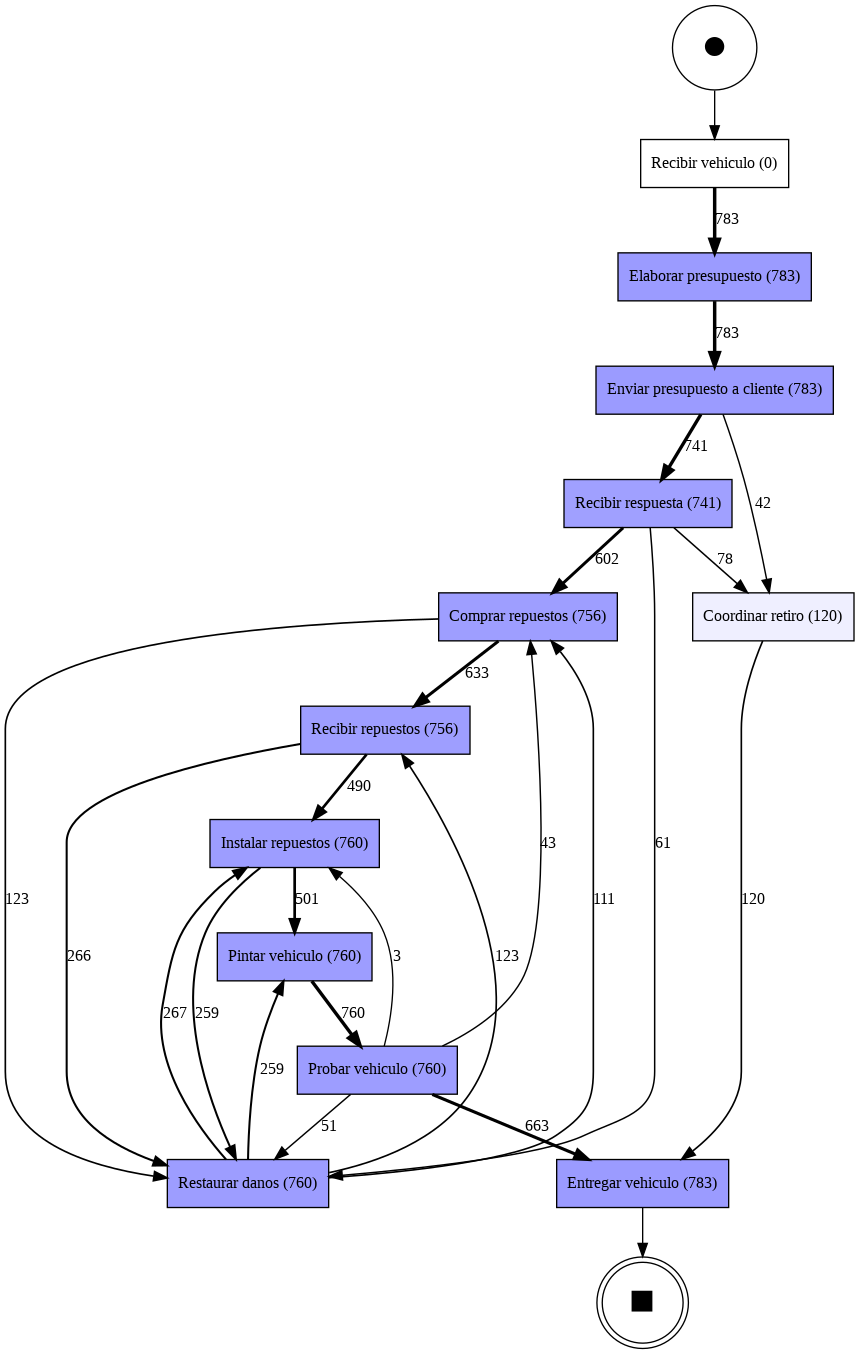

In [ ]:
dfg = footprints_filtrado['dfg']

start_activities = footprints_filtrado['start_activities']

end_activities = footprints_filtrado['end_activities']

pm4py.vis.view_dfg(dfg,
                   start_activities,
                   end_activities,
                   format = 'png',
                   rankdir='TB'
                  )

Adicionalmente, el módulo pm4py tiene la funcionalidad de convertir entre notaciones. Para ello provee varias funciones de conversión, visualización y guardado de modelos.

Para ejemplificarla convertiremos la red que resultó en un modelo bpmn usando `convert.convert_to_bpmn()` y luego lo mostraremos usando `vis.view_bpmn()`.

In [ ]:
bpmn = pm4py.convert.convert_to_bpmn(net, initial_marking, final_marking)

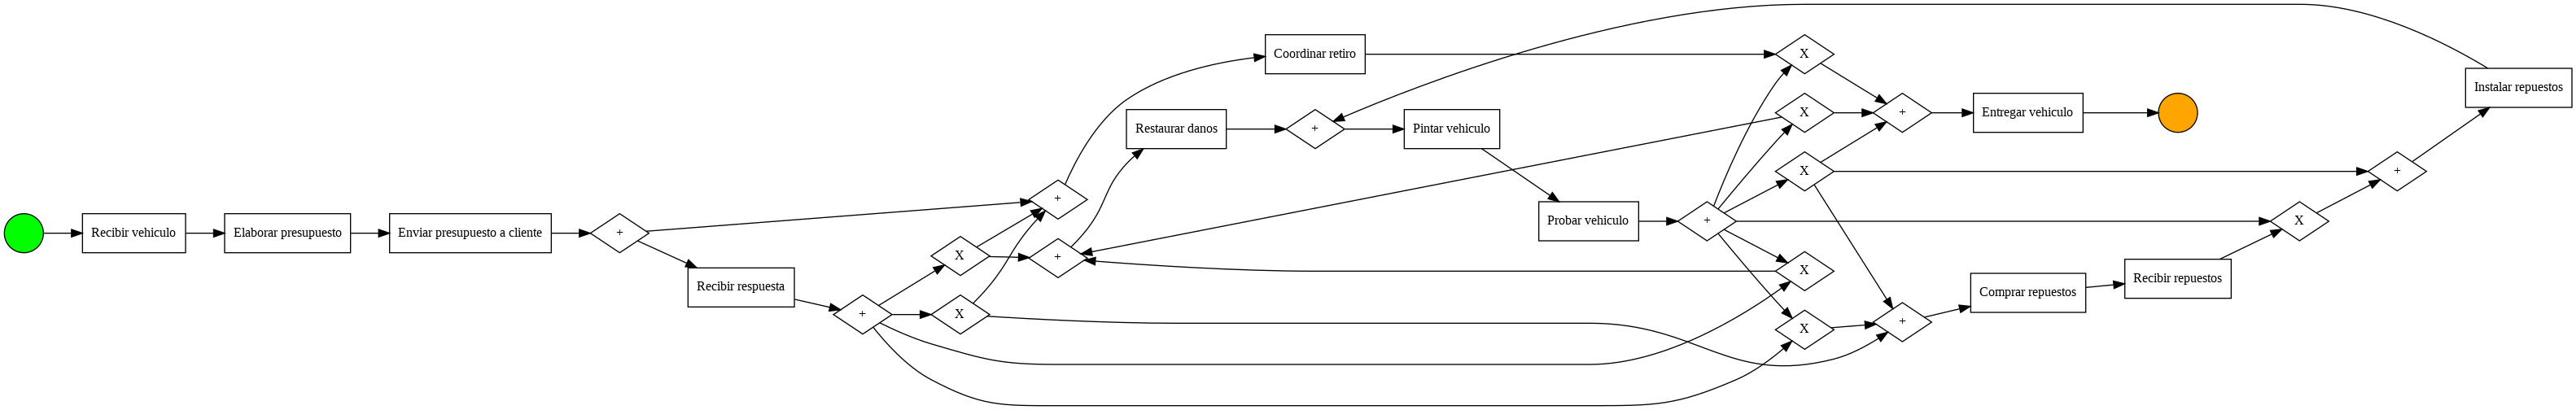

In [ ]:
pm4py.vis.view_bpmn(bpmn)